# Course Four: Build a Regressor

Expected time to complete: XX minutes

## Goal of this Course
During this course we will build a regressor to forecast the minutes watched within the last two-week group.

This course is split into the following parts:
- <a href='#context'>Context</a> 
- <a href='#model_evaluation'>Model Evaluation</a> 
- <a href='#baseline_forecast'>Baseline Forecast</a>
    - <a href='#load_data'>Load the Data</a>
    - <a href='#define_baseline'>Define a Baseline</a>


- <a href='#linear_reg'>Multivariate Linear Regression</a>
    - <a href='#model_training'>Model Training and Evaluation</a>
    - <a href='#out_sample_error'>Out-of-Sample Error</a>
    - <a href='#in_sample_error'>In-Sample Error and Estimated Coefficients</a>


- <a href='#ridge_reg'>Ridge Regression</a>
    - <a href='#model_training2'>Model Training and Evaluation</a>
    - <a href='#best_ridge_reg'>Interpreting Ridge Regression Model</a>


- <a href='#lasso_reg'>Lasso Regression</a>
    - <a href='#model_training3'>Model Training and Evaluation</a>
    - <a href='#best_lasso_reg'>Interpreting Lasso Regression</a>

<a id='context'></a>
# Context
In the previous tutorial we explained how the training process works and how to evaluate our models in the classification framework. We built four models that predicted whether a user would consume content within a two-week period based upon their past behaviour over the previous 16 weeks. 

Forecasting whether or not a given user will return to BBC services is very useful for the BBC. It provides valuable insight and feedback on the way we are surfacing content to our users and, in particular,  identifies the users where we need to do better.

Data on the engagement of returning audience members is also useful. From the pool of audience members that did return, there will be valuable variation in the amount of content they consume. The aim of this current tutorial is to forecast the _volume_ of content consumed by an audience member within a two-week period, based upon their consumption behaviour in the previous 16 weeks. 

In order to forecast the minutes watched within the final two-week group we will first define our evaluation metric. As we did for the classifiers in the previous tutorial, we will then train different models, compare their performances to a baseline and benchmark their results. 


<a id='model_evaluation'></a>
# Model Evaluation

Evaluating the performance of a regressor is slightly less straightforward than a classifier although it is based upon the same principle: we define an error, then compare the error of our model to the expected error of a random model.   

For regressors, the error is computed as the average residual between the actual observations and the model predictions. 

__Root mean squared error__ (RMSE) and __mean absolute error__ (MAE) are two commonly used examples of these. Once we have a representation of the error produced by the model we can compare that error with the error of the most simple model of the data (usually the mean). The statistic that reflects this difference is known as the coefficient of determination or __R-squared__. R-squared measures the goodness-of-fit of a model and can be thought of as the proportion of variance in the model output variable (y) that is captured by our model.

<a id='baseline_forecast'></a>
# Baseline Forecast

<a id='load_data'></a>
## Load the Data
First, let's get our data back and check to make sure it looks familiar.

In [154]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [155]:
# We put both target arrays (regression and classification) in the same txt file
# As both target arrays have the same size we just need to split it it two
# and get the correct part for the prediction task
target = np.split(np.loadtxt('target.txt'), 2)[0].flatten()
features = pd.read_csv('features.csv')

# User id as index
features = features.set_index('user_id')

In [156]:
# Make sure we have the right input database
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,num_genre,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,1,...,1,0,0,0,0,0,0,1,0,0
000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,5,...,0,0,1,0,0,0,0,0,1,0
001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,2,...,0,1,0,0,0,0,0,0,1,0
001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,2,...,0,0,0,0,0,1,0,0,1,0
002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,5,...,0,1,0,0,0,0,0,1,0,0


In [157]:
# Make sure we have the right output
target[:10]

array([  1.44833333e-01,   3.18047633e+02,   1.98035000e+00,
         1.00590667e+01,   0.00000000e+00,   4.79261667e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

<a id='define_baseline'></a>
## Define a Baseline

As mentionned in the previous course we should have a baseline to compare the performance of our models with. Here, as we are forecasting a quantitative variable, the most simple model is the one that predicts a constant value, such as  zero, the mean or the median of our data. 

Note that by default `scikit` _maximises_ an inverse error function as opposed to minimising an error function.  We therefore negate the error we compute for our baseline model to make it comparable with the performance metric we will pull out of our statistical models.

In [158]:
# Create a baseline to compare our results to (mean and median minutes watched and 0)
mean=np.mean(target)
median=np.median(target)

mean_forecast=[mean]*len(target)
median_forecast=[median]*len(target)
zero_forecast=[0]*len(target)

In [159]:
print("Mean: "+str(mean))
print("Median: "+str(median))

Mean: 75.9168097123
Median: 0.0


The median is null, meaning that more than half of our users did not consume content on iPlayer within the last two weeks.

There is no need to consider the constant model equal to 0 as a baseline here (same as the median one).

In [160]:
# Compute the errors for these different baselines
from sklearn import metrics
print("Score if we forecast the mean:",
      -metrics.mean_absolute_error(target,mean_forecast))
print("Score if we forecast the median:",
      -metrics.mean_absolute_error(target,median_forecast))

Score if we forecast the mean: -115.319756974
Score if we forecast the median: -75.9168097123




We will now train a series of different kinds of regression models. The impact of each of these models can be assessed by comparing their performance to these two baseline error scores. 

These models should provide great business insight as we can __quantify the impact__ of each input variable upon our "engagement" output variable.

<a id='linear_reg'></a>
# Multivariate Linear Regression

The easiest way to relate our output variable to our input ones is to use a __linear combination__.

A linear regression model decomposes the observed output in an additive way such that the coefficients we estimate in the training process can be interpreted as the impact of a given input all other things being equal (AOTBE). For more details see: https://en.wikipedia.org/wiki/Linear_regression

And for the `scikit learn` documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [161]:
# Let's build a simple regression
from sklearn import linear_model

# We will use cross validation, so import helper functions for this
from sklearn.model_selection import cross_val_score, cross_val_predict

# Plots
from matplotlib import pyplot as plt 

<a id='model_training'></a>
## Model Training and Evaluation

For this model there is no hyperparameter to tune. Indeed, the model only has to evaluate the _contribution_ of each input variable to the linear combination.  

Mainintaining a train/test split is just as important when using regression models as it is with classification models, so we will use the `cross_val_score` function again here. This gives us the negative mean absolute error for each of the _k_ validation folds. In addition we use the 'cross_val_predict' function to get the raw linear predictions. This function returns the predicted target value of each datapoint in our dataset while ensuring the model used to predict each datapoint has not been trained upon that datapoint.

In [162]:
# We setup a simple linear regression, again using cross validation
reg=linear_model.LinearRegression()


MR_oos=cross_val_score(reg, features, target, scoring='neg_mean_absolute_error')
MR_r2 = cross_val_score(reg, features, target, scoring='r2')
predicted=cross_val_predict(reg, features,target)

In [163]:
# Compute the mean error obtained in the CV
print("Mean inverse out-of-sample error:", np.mean(MR_oos))

Mean inverse out-of-sample error: -58.0733721136


So we now have an indication of the performance of our first regressor model. Fortunately, the score is higher than either of our baseline scores (-115 and -76) meaning that our model is capturing some meaningful information about our output "engagement" variable.

We can also plot our predicted values against the output we actually observe. The more the dots are close to the first bisector, the better are our forecasts. 

We can also evaluate the strength of the linear relationship between the predicted and actual output values by calculating the correlation of the two.

Pearson correlation coefficient: 0.7989190750106413
P-value 0.0


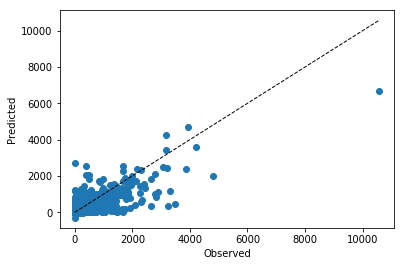

In [164]:
#First let's see how correlated the predicted and actual output variables are.
from scipy.stats.stats import pearsonr
MR_r, p  = pearsonr(target,predicted)
print('Pearson correlation coefficient: {}'.format(MR_r) )
print("P-value {}".format(p))


# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')



plt.show()

So a correlation coefficient 0.8 represents a strong linear relationship between the two variables. The P-value of 0.0 represents the significance of the test. The P-value is a number between 0 and 1 and can be interpreted as the probability that the reported effect is not real and actually happened by chance. In most behavioural studies p-values of below 0.05 are considered significant. Be aware that this significance level is, essentially, arbitrary and varies from field to field. 


From inspecting the scatter plot we see the illustration of the reported linear relationship. One thing to note from the plot is that an outlier exists in the top right corner of the plot. It is worth mentioning that a single outlier like that can have a significant impact upon correlation coefficient. So, for a more accurate reflection of the linear relationship, that outlier should be removed before performing the correlation test.


<a id='in_sample_error'></a>
## Interpreting Multivariate Regression Model

Now that we have evaluated the performance of our model using the out-of-sample error, next, let's see if we can understand how the model is working. To do this, we will train one model using our entire dataset and the estimated coefficients will represent the importance the model is affording to each feature.

In [165]:
# Let's train on all data 
lin_reg=linear_model.LinearRegression()
mod1=lin_reg.fit(features,target)

In [166]:
# In-sample error
from sklearn.metrics import mean_absolute_error
MR_is = -metrics.mean_absolute_error(target,mod1.predict(features))
print("Inverse in-sample error: {}".format(MR_is))

# Calculate the goodness-of-fit Coefficient of determination - r-squared
#MR_r2 = mod1.score(features,target)
#print("R-squared: {}".format(MR_r2))

Inverse in-sample error: -56.600083327149065


So our _inverse_ in-sample error is -56.6 while our _inverse_ out-of-sample (average) error is -58. This looks sensible as, remember that _inverse_ in-sample error (or in-sample accuracy) will always be higher than _inverse_ out-of-sample error (or out-of-sample-accuracy). The fact that these two values are not far apart is an indication that the model is well-fitted.

N.B For the estimated coefficients we should in theory have a look at the __p-values__ for each - statistic values that indicate whether our estimated coefficient is significantly different from zero. We won't go more into details here, however they can be explored in the sci-kit learn documentation. 

In [167]:
# First, let's have a look at the highest magnitude positive coefficients.
coef1=pd.DataFrame(
    {'feature': list(features.columns),
     'coefficient': list(mod1.coef_)
    })
coef1.sort_values(by='coefficient', ascending=False).reset_index(drop=True).head(10)


,coefficient,feature
0,6.541515,most_weekday_weekday_2
1,4.831388,most_genre_Sport
2,3.625429,most_genre_Drama
3,2.676683,most_timeday_Afternoon
4,2.654163,most_genre_News
5,2.148542,most_genre_Entertainment
6,1.889999,most_weekday_weekday_6
7,1.302314,num_genre
8,1.081513,most_genre_Religion & Ethics
9,0.849109,average_completion


In [168]:
# Now lets have a look at the highest magnitude negative coefficients.
coef1.sort_values(by='coefficient', ascending=False).reset_index(drop=True).tail(5)

,coefficient,feature
29,-6.872885,most_genre_Music
30,-7.023103,most_timeday_Evening
31,-8.022035,most_timeday_Night
32,-9.211985,most_weekday_weekday_0
33,-16.821276,most_genre_Children's


In [169]:
# Make the index the feature label.
coef1 = coef1.set_index(['feature'])

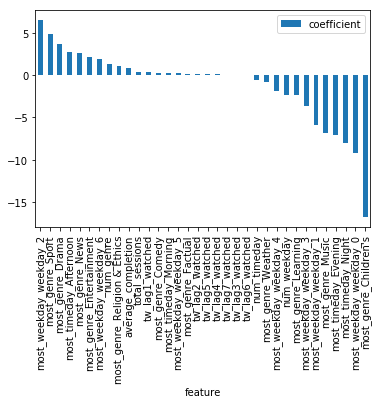

In [170]:
# Now let's plot them all
coef1.sort_values(by='coefficient', ascending=False).plot(kind='bar')
plt.show()


The results are quite interesting here. It seems that some particular habits __drive__ the amount of content consumed. The table of positive coefficients indicate the features that are positively correlated with minutes watched. So, users that consume most iPlayer content on Wednesdays, or in the afternoon, or whose favourite genre is Sport are more likely to consume more content overall. Conversely, users whose favourite genre is Children's or who consume most of their content on a Monday do not consume - in terms of total of minutes - as much. It's difficult to speak of drivers for _engagement_ here because the minutes watched is highly correlated to the type of content. For example, Children's  content are, on average, shorter than Sport or Drama so it makes sense that people that watch long shows watch more minutes than people that watch short shows. It doesn't necessarily mean than the user's who consume only Children's content are less engaged. 

More specifically, the estimated coefficients can be interpreted as follows. Let's take the `num_genre` variable, whose estimated coefficient and therefore model contribution is 1.3. This means that, if we hold all other features constant, for each user that views one genre in the 16-week training period (`num_genre=1`), the model output prediction will be 1.3 minutes of consumed content.  While this feature alone would not make a very accurate model for our purpose, it makes sense that the more genre's an audience member consumes, the more engaged they are.

To be certain that the the coefficients of our model are making significant contributions, we should also look at the p-values for each. A p-value of below 0.05 indicates that an estimated coefficient is significantly different from zero. The reader is encouraged to explore this as an exercise.

## Results

In [171]:
print("Multivariate regression results:")
print("Inverse in-sample error: {}".format(np.mean(MR_is)))
print("Inverse out-of-sample error: {}".format(np.mean(MR_oos)))
print("Correlation between predicted and actual: {}".format(MR_r))
print("R-squared: {}".format(np.mean(MR_r2)))

Multivariate regression results:
Inverse in-sample error: -56.600083327149065
Inverse out-of-sample error: -58.07337211361497
Correlation between predicted and actual: 0.7989190750106413
R-squared: 0.6249690423640981





# Regularization Models

In many situations, trained multivariate linear regression models have very large coefficients. Unfortunately, experience tells that large coefficients tend to lead to more complex models that overfit the data. _Regularization_ models various techniques to avoid this problem.

<a id='ridge_reg'></a>
# Ridge Regression



Ridge regression, also referred to as L2 regularization is a variant of multivariate regression that adds a term, _alpha_, that penalises the sum-squared of the coefficients. In practical terms, an alpha of zero will train a model that is identical to multivariate regression and as we increase _alpha_ the magnitude of the coefficients will be increasingly constrained.

`scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

<a id='model_training2'></a>
## Model Training and Evaluation

The _alpha_ term just described is a hyperparameter that we need to tune.  Let's use the same approach we used for the classification models and do a grid search.

In [172]:
# Setup the model and develop a simple grid search against some key parameters
param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [173]:
# Let's keep track of our best parameters
RR_best_score=-200
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_alpha:
    reg_r = linear_model.Ridge(alpha = i)
    scores=cross_val_score(reg_r,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    
    if np.mean(scores)>RR_best_score:
        RR_best_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: alpha:',best_param)
print('Inverse oout-of-sample error:', RR_best_score)

Best Settings: alpha: 100
Inverse oout-of-sample error: -57.6212395997


So our best ridge regression model does _slightly_ better than our previous multivariate regression model.

Now let's look at the relationship between the predicted and actual values.

Pearson correlation coefficient: 0.7991074107638553
P-value 0.0


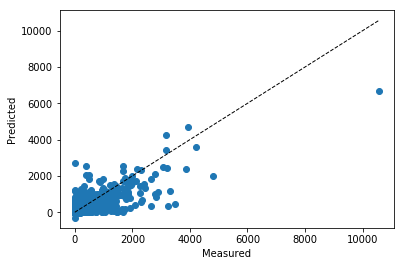

In [174]:
reg_r = linear_model.Ridge(alpha = best_param)
predicted=cross_val_predict(reg_r, features,target)
RR_r, p  = pearsonr(target,predicted)
print('Pearson correlation coefficient: {}'.format(RR_r) )
print("P-value {}".format(p))


# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

The data (both the plot and the correlation coefficient) look very similar to the data produced by the previous linear regression model so there are no more insights to be made here.

In [175]:
# Save performance data for benchmarking later
reg_r = linear_model.Ridge(alpha = best_param)
RR_oos=cross_val_score(reg_r, features, target, scoring='neg_mean_absolute_error')
RR_r2 = cross_val_score(reg_r, features, target, scoring='r2')





<a id='best_ridge_reg'></a>
## Interpreting Ridge Regression Model

As before, to explore our best ridge regression model we will train a new model using the entire dataset.

In [176]:
# Let's keep our best model (hyperparameters tuned)
ridge=linear_model.Ridge(alpha = best_param)
mod2=ridge.fit(features,target)

In [177]:
# In-sample error
RR_is = -metrics.mean_absolute_error(target,mod2.predict(features))
print("Inverse in-sample error: {}".format(RR_is))

# Coefficient of determination - r-squared
#RR_r2 = mod2.score(features,target)
#print(RR_r2)

Inverse in-sample error: -56.349642485604285


The in-sample performance metric looks sensible.



Now let's look at the coefficients, where we should see a difference from our linear regression model.

In [178]:
# Let's have a look at the estimated coefficients
coefRidge=pd.DataFrame(
    {'feature': list(features.columns),
     'coefficient': list(mod2.coef_)
    })
# Make the index the feature label.
coefRidge = coefRidge.set_index(['feature'])

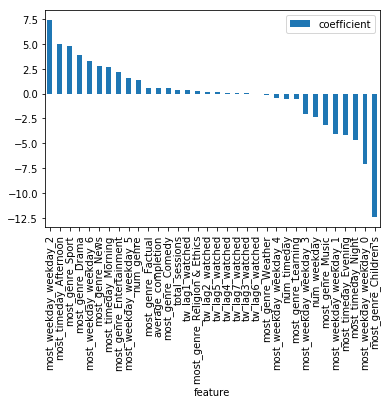

In [179]:
coefRidge.sort_values(by='coefficient', ascending=False).plot(kind='bar')
plt.show()



As expected, the shape of the distribution of coefficients has not changed noticebly, however, the absolute values of those coefficients is much lower than it was for the linear regression model.

## Results


In [180]:
print("Ridge regression results:")
print("Inverse in-sample error: {}".format(np.mean(RR_is)))
print("Inverse out-of-sample error: {}".format(np.mean(RR_oos)))
print("Correlation between predicted and actual: {}".format(RR_r))
print("R-squared: {}".format(np.mean(RR_r2)))

Ridge regression results:
Inverse in-sample error: -56.349642485604285
Inverse out-of-sample error: -57.62123959970442
Correlation between predicted and actual: 0.7991074107638553
R-squared: 0.6252643592161196



<a id='lasso_reg'></a>
# Lasso Regression

Lasso regression is another variant of multivariate regression and is often referred to as L1 regularisation. Instead of penalising the sum-squared of the coefficients (as in ridge regression), lasso regression penalises the absolute sum square of the coefficients. In practical terms, this has the effect of limiting the number of non-zero coefficients in the model. This makes lasso regression a convenient method of feature selection.

`scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

<a id='model_training3'></a>
## Model Training and Evaluation

Again, we need to tune the penalty parameter _alpha_. In lasso regression, the _alpha_ parameter varies the number of non-zero coefficients. An _alpha_ of zero will produce a model that is equal to linear regression and as _alpha_ increases the number of non-zero coefficients is increasingly constrained.

In [181]:
# Setup the model and develop a simple grid search against some key parameters
param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [182]:
# Let's keep track of our best parameters
best_score=-200
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_alpha:
    reg_l = linear_model.LassoLars(alpha = i)
    scores=cross_val_score(reg_l,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    if np.mean(scores)>best_score:
        best_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: alpha:',best_param)
print('Score:', best_score)

Best Settings: alpha: 0.1
Score: -56.2569583055


So our best alpha parameter is 0.1 and our best performance metric is -56, which is marginally better than both of our previous models (achieving -58 and 57.6).



Pearson correlation coefficient: 0.7999888895572336
P-value 0.0


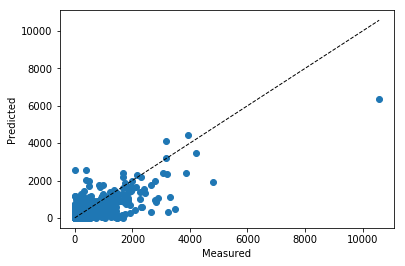

In [183]:
reg_l = linear_model.LassoLars(alpha = best_param)
predicted = cross_val_predict(reg_l, features,target)
LR_r, p  = pearsonr(target,predicted)

print('Pearson correlation coefficient: {}'.format(LR_r) )
print("P-value {}".format(p))

# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Again, the scatter plot and correlation statistics look very similar to those generated using data from our previous regression models. So there are no further insights to be made here.

In [184]:
# Save performance data for benchmarking later
reg_l = linear_model.LassoLars(alpha =  best_param)
LR_oos=cross_val_score(reg_l, features, target, scoring='neg_mean_absolute_error')
LR_r2 = cross_val_score(reg_l, features, target, scoring='r2')

<a id='best_lasso_reg'></a>
## Interpreting Lasso Regression Model



In [185]:
# Let's keep our best model (hyperparameters tuned)
lasso=linear_model.LassoLars(alpha = best_param)
mod3=lasso.fit(features,target)

In [186]:
# In-sample error
LR_is = -metrics.mean_absolute_error(target,mod3.predict(features))
print(LR_is)

# Coefficient of determination - r-squared
#LR_r2 = mod3.score(features,target)
#print(LR_r2)

-55.8993812974


Our in-sample error looks sensible. Now let's look at the relationship between the real and predicted model values.

We should expect to see quite significant differences in the distribution of coefficients in our lasso model due to how it penalises the number of non-zero weights.

In [187]:
# Let's have a look at the estimated coefficients
coefLasso=pd.DataFrame(
    {'feature': list(features.columns),
     'coefficient': list(mod3.coef_)
    })
# Make the index the feature label.
coefLasso = coefLasso.set_index(['feature'])

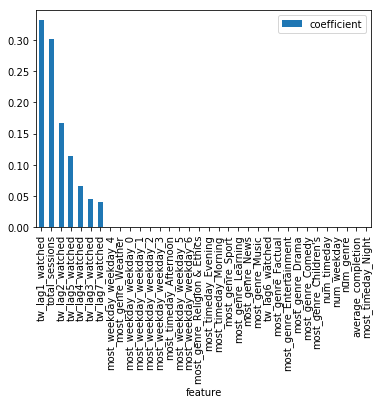

In [188]:
coefLasso.sort_values(by='coefficient', ascending=False).plot(kind='bar')
plt.show()


So, as expected we see a drastically different distribution of coefficients to our previous two models, with only seven of the original thrirty-four coefficients included.  Interestingly, the lasso model has also chosen very different features to the ones weighted highest by the previous two models. The previous two models achieve their highest accuracy from quite a complex combination of positive and negative coefficients that describe the most frequent genre of content and viewing time; while they weighted minutes watched in previous weeks relatively low. Conversely, the lasso model improves on those  previous models by throwing out all the genre and viewing time features and including just seven positive coefficients that weight the minutes watched in previous weeks. 

## Results



In [189]:
print("Lasso regression results:")
print("Inverse in-sample error: {}".format(np.mean(LR_is)))
print("Inverse out-of-sample error: {}".format(np.mean(LR_oos)))
print("Correlation between predicted and actual: {}".format(LR_r))
print("R-squared: {}".format(np.mean(LR_r2)))

Lasso regression results:
Inverse in-sample error: -55.899381297386455
Inverse out-of-sample error: -56.25695830551189
Correlation between predicted and actual: 0.7999888895572336
R-squared: 0.6272392842296312


# Benchmarking Regressor Models

Now we have calculated performance metrics for three different regression models let's plot and compare their performances.

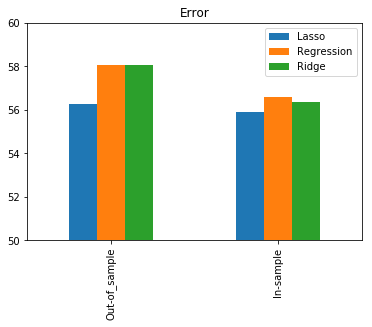

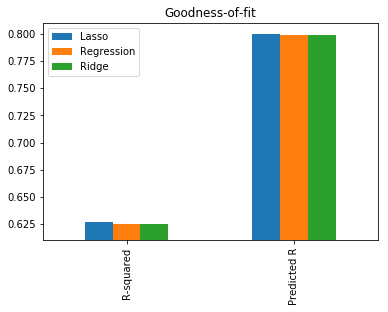

In [190]:

# We will negate the inverse errors to make the bar plots more presentable.
bm_errors = pd.DataFrame({'Regression':[-np.mean(MR_oos),-np.mean(MR_is)],
                          'Ridge':[-np.mean(RR_oos),-np.mean(RR_is)],
                          'Lasso':[-np.mean(LR_oos),-np.mean(LR_is)]})

bm_r2 = pd.DataFrame({'Regression':[np.mean(MR_r2),MR_r],
                          'Ridge':[np.mean(RR_r2),RR_r],
                          'Lasso':[np.mean(LR_r2),LR_r]})
bm_inverse_errors.plot(kind='bar')
plt.title("Error")
plt.xticks( np.arange(2), ('Out-of_sample', 'In-sample') )
plt.ylim((50,60,))
plt.show()

bm_r2.plot(kind='bar')

plt.title("Goodness-of-fit")
plt.xticks( np.arange(2), ('R-squared', 'Predicted R') )
plt.ylim((0.61,0.81))
plt.show()

We can see from both these plots that the performance of our regression models are difficult to tell apart. The original multivariate regression model and the ridge regression are particularly difficult to distinguish while the lasso model exhibits marginally the best performance for all metrics.

On the basis of these results, it is likely that each of the three models would not perform significantly better than each other on new data but if we follow _Occam's razor_, the lasso model makes the fewest assumptions, is the least complex and is therefore most likely to generalise to new data.



<a id='combine'></a>
# Combine the Regression and Classification Models
and generate an overall score 


# Summary

In this tutorial we have explored how to train statistical models that can handle linear output variables: regressors.

- We looked at the different ways in which the preformance of a regression model can be evaluated and the importance of establishing a baseline of error.
- We used our data to train three different types of regression models and evaluated their performance: multivariate linear regression; ridge regression and lasso regression.
- We learnt about the concept of _regularization_: an approach that aims to reduce the problem of very large coefficients in regression models, which can lead to overfitting.
- We learnt how to interpret a regression model by inspecting the coeffcients. Here we found clear differences between the three models, giving us a more unituitive understanding of how the workings of the models differed.

# General Summary

Over the four tutorials in this course, we have covered a lot. You may not feel like an expert data science yet but if you fee comfortable with everything we have done so far, you are certainly on your way there. 

To recap, the first tutorial helped us understand how to formulate our data science problem and select the dataset we need to solve it. We decided that it would be useful to try and predict engagement statistics of users within a two-week period, based upon their viewing behaviour in the previous 16 weeks. To solve this problem we decided to use a dataset containing the views of 10,000 iPlayer viewers.

In the second tutorial we introduced the concept of data wrangling - transforming and preparing our dataset so that it is ready to be ingested into our statistical learning models. It is these models that alllow us to make engagement  predictions and forecasts about our users.

In the third tutorial, we were introduced to our first classifier models: how to train them and how to evaluate their performance. We used four classifiers to forecast whether or not a user was "engaged" with iPlayer, based upon their viewing behaviour of the previous 16 weeks.

In this final tutorial, we introduced our first regression models. These allowed us to forecast the amount of engagement with iPlayer content during a two-week period, based upon their viewing behaviour over the previous 16 weeks. 

We hope you enjoyed joining us on this course and that you found it helpful in your development as a world-leading data scientist!

-Datalab Team